## Project Overview: UNHCR Refugee Flow Classification
### Objective:
To build a classification model that predicts the protection type (PT) of a refugee flow record (e.g., REF = Refugee, ASY = Asylum Seeker, etc.) based on the origin, destination, year, and other characteristics of the refugee movement.

In [30]:
# Importing the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, roc_curve, auc, RocCurveDisplay

### Understanding the data.

In [18]:

# Load the main data sheet
df = pd.read_excel('UNHCR_Flow_Data.xlsx', sheet_name="DATA")

# Preview the first few rows
print(df.shape)
df.head()


(103343, 10)


,origin,OriginISO,OriginName,asylum,AsylumISO,AsylumName,AsylumRegion,PT,Year,Count
0,ALG,DZA,Algeria,MTA,MLT,Malta,Europe,REF,1962,5
1,ANG,AGO,Angola,COD,COD,Dem. Rep. of the Congo,Southern Africa,REF,1962,20000
2,ANG,AGO,Angola,NAM,NAM,Namibia,Southern Africa,REF,1962,277
3,BDI,BDI,Burundi,NAM,NAM,Namibia,Southern Africa,REF,1962,13
4,CHI,CHN,China,NEP,NPL,Nepal,Asia and the Pacific,REF,1962,5


In [19]:
# Shape and data types
print(df.shape)
print(df.dtypes)

# Basic stats
df.describe(include='all')


(103343, 10)
origin          object
OriginISO       object
OriginName      object
asylum          object
AsylumISO       object
AsylumName      object
AsylumRegion    object
PT              object
Year             int64
Count            int64
dtype: object


,origin,OriginISO,OriginName,asylum,AsylumISO,AsylumName,AsylumRegion,PT,Year,Count
count,103343,103343,103308,103343,103343,103343,103306,103343,103343.000000,1.033430e+05
unique,214,214,213,187,187,187,7,4,NaN,NaN
top,COD,COD,Dem. Rep. of the Congo,CAN,CAN,Canada,Europe,ASY,NaN,NaN
freq,2261,2261,2261,4965,4965,4965,63130,97389,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.636599,1.047341e+03
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.189355,1.651208e+04
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962.000000,5.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.000000,7.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,2.300000e+01
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,1.320000e+02


In [20]:
df.isnull().sum()


origin           0
OriginISO        0
OriginName      35
asylum           0
AsylumISO        0
AsylumName       0
AsylumRegion    37
PT               0
Year             0
Count            0
dtype: int64

For modeling, rows with missing critical features will be dropped.

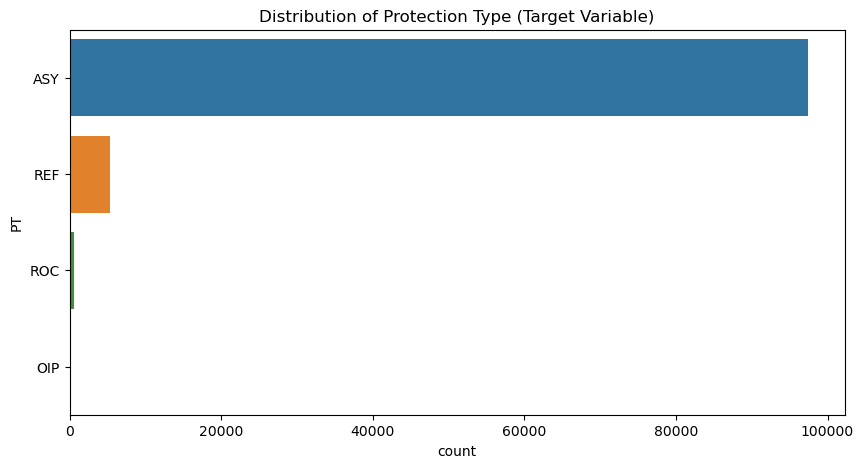

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(y='PT', data=df, order=df['PT'].value_counts().index)
plt.title('Distribution of Protection Type (Target Variable)')
plt.show()


The class distribution confirms what was suspected: the dataset is heavily imbalanced, with the vast majority of records labeled as "ASY" (Asylum Seekers).

In [22]:

# Top 10 origin countries
print(df['OriginISO'].value_counts().head(10))

# Top 10 asylum countries
print(df['AsylumISO'].value_counts().head(10))

# Top asylum regions
print(df['AsylumRegion'].value_counts())


COD    2261
SOM    2146
IRQ    2117
SYR    2035
AFG    1989
SDN    1965
IRN    1868
ETH    1803
NGA    1786
PAK    1773
Name: OriginISO, dtype: int64
CAN    4965
DEU    4788
USA    4649
FRA    4010
CHE    3715
BEL    3654
GBR    3568
SWE    3456
NLD    3453
ESP    2958
Name: AsylumISO, dtype: int64
Europe                                      63130
Americas                                    15786
Asia and the Pacific                         9078
Middle East and North Africa                 5681
West and Central Africa                      3781
Southern Africa                              3362
East and Horn of Africa, and Great Lakes     2488
Name: AsylumRegion, dtype: int64


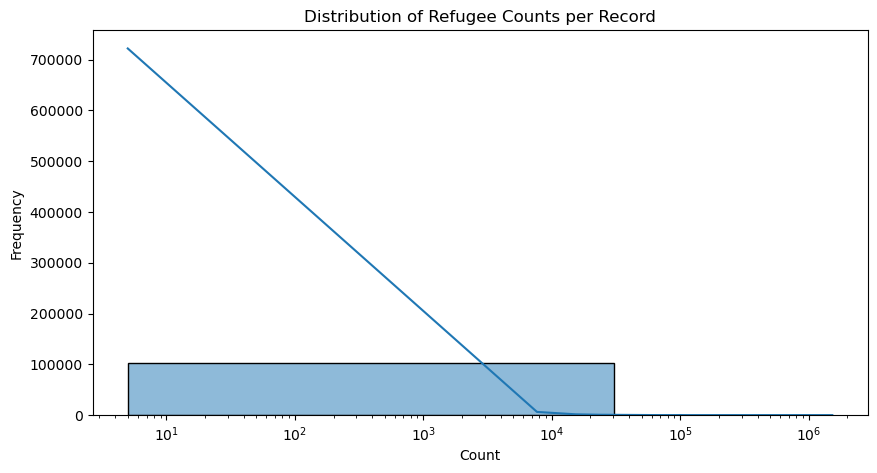

In [23]:
# Count distribution
plt.figure(figsize=(10,5))
sns.histplot(df['Count'], bins=50, kde=True)
plt.title('Distribution of Refugee Counts per Record')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xscale('log')  # Skewed data — use log scale
plt.show()


### Trends over time.

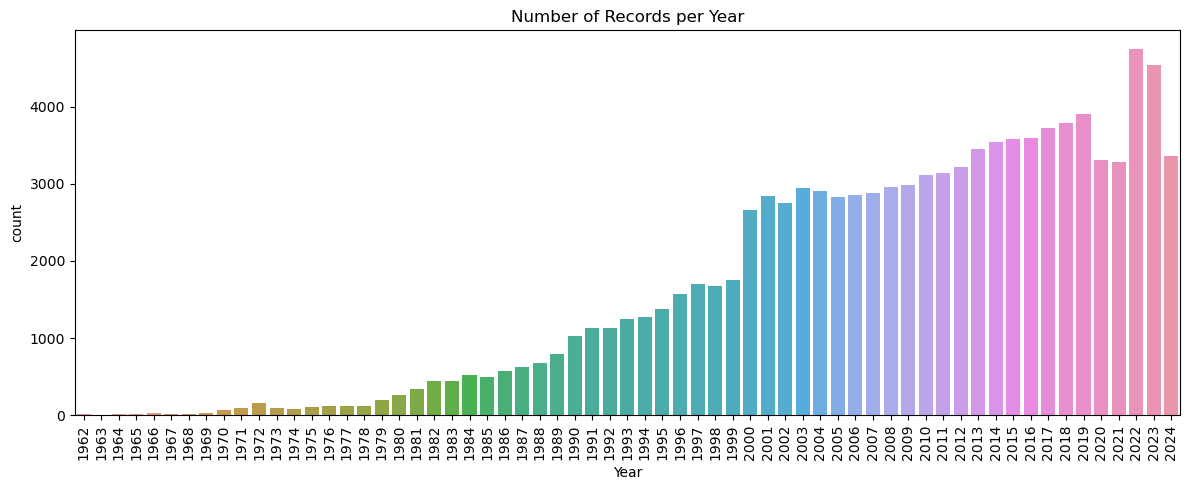

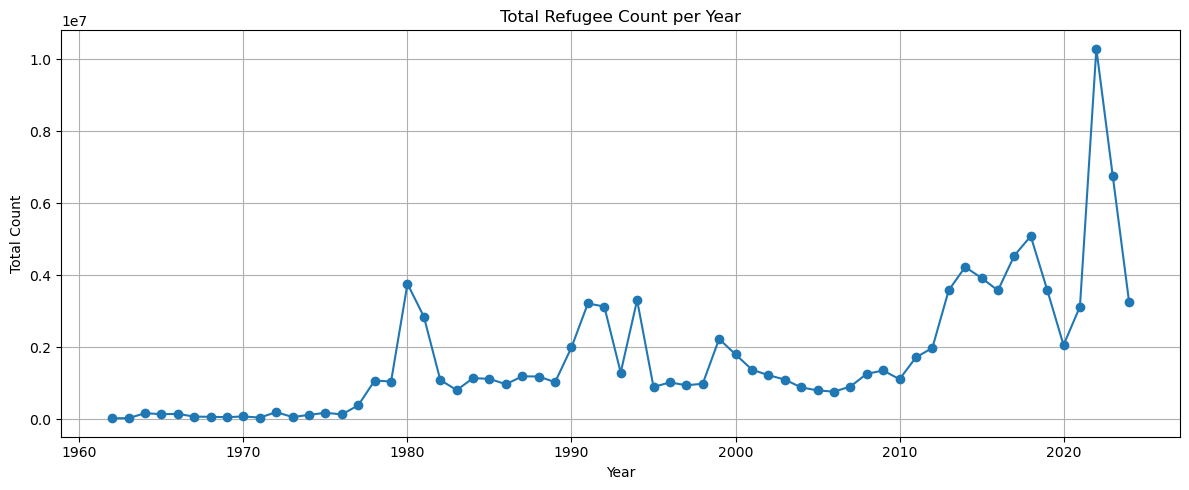

In [24]:
# Number of entries per year
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='Year')
plt.title('Number of Records per Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Total number of refugees per year
yearly_counts = df.groupby('Year')['Count'].sum()
plt.figure(figsize=(12,5))
yearly_counts.plot(kind='line', marker='o')
plt.title('Total Refugee Count per Year')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import scipy.stats as stats

# Cross-tab and chi-squared test
crosstab = pd.crosstab(df['AsylumRegion'], df['PT'])
chi2, p, dof, ex = stats.chi2_contingency(crosstab)

print("Chi-squared Test")
print("Chi2 Stat:", chi2)
print("p-value:", p)


Chi-squared Test
Chi2 Stat: 10576.759344878405
p-value: 0.0


 A Chi-squared statistic of 10,576.76 with a p-value of 0.0 means there's a very strong association between the asylum region and the protection type (PT). That’s useful insight:

-- It confirms that AsylumRegion is likely an important predictor.

-- We should definitely retain and encode this feature in the modeling phase.

### Feature engineering

In [26]:
# Drop columns not useful for prediction
df_cleaned = df.drop(columns=["OriginISO", "OriginName", "AsylumISO", "AsylumName"])


In [27]:
# Check missing values
print(df_cleaned.isnull().sum())

# Drop rows with missing PT (target variable)
df_cleaned = df_cleaned.dropna(subset=['PT'])

# Drop rows with missing values in essential features
df_cleaned = df_cleaned.dropna(subset=['AsylumRegion', 'Count'])


origin           0
asylum           0
AsylumRegion    37
PT               0
Year             0
Count            0
dtype: int64


In [28]:
df_cleaned.isnull().sum()

origin          0
asylum          0
AsylumRegion    0
PT              0
Year            0
Count           0
dtype: int64

In [31]:
# Encode the target
le = LabelEncoder()
df_cleaned['PT_encoded'] = le.fit_transform(df_cleaned['PT'])
print("Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Features and target
X = df_cleaned.drop(columns=['PT', 'PT_encoded'])
y = df_cleaned['PT_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Build pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred = rf_pipeline.predict(X_test)

# Evaluate
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Label Mapping: {'ASY': 0, 'OIP': 1, 'REF': 2, 'ROC': 3}
Random Forest Classification Report:
              precision    recall  f1-score   support

         ASY       0.98      0.99      0.99     19479
         OIP       0.89      0.44      0.59        18
         REF       0.84      0.67      0.75      1060
         ROC       0.38      0.25      0.30       105

    accuracy                           0.97     20662
   macro avg       0.77      0.59      0.66     20662
weighted avg       0.97      0.97      0.97     20662



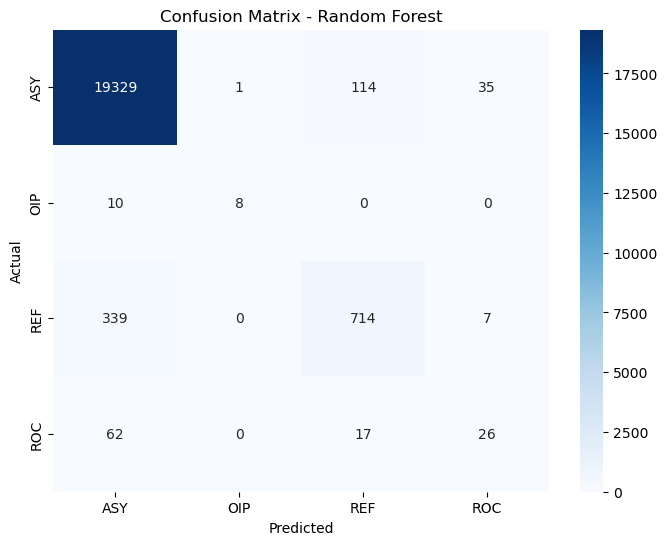

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Building and comparing other models.

In [33]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(probability=True)
}

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"🔍 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_))
    print('-' * 60)


🔍 Random Forest Accuracy: 0.9717
              precision    recall  f1-score   support

         ASY       0.98      0.99      0.99     19479
         OIP       0.89      0.44      0.59        18
         REF       0.84      0.67      0.75      1060
         ROC       0.38      0.25      0.30       105

    accuracy                           0.97     20662
   macro avg       0.77      0.59      0.66     20662
weighted avg       0.97      0.97      0.97     20662

------------------------------------------------------------
🔍 Logistic Regression Accuracy: 0.9553
              precision    recall  f1-score   support

         ASY       0.96      1.00      0.98     19479
         OIP       0.88      0.39      0.54        18
         REF       0.88      0.27      0.41      1060
         ROC       0.50      0.05      0.09       105

    accuracy                           0.96     20662
   macro avg       0.80      0.43      0.50     20662
weighted avg       0.95      0.96      0.94     2066

### Insights
Accuracy is heavily driven by the dominant class (ASY, ~94% of data). So we must also consider recall and F1 for minority classes.

Random Forest balances things better — decent recall for REF and ROC, even with class imbalance.

Logistic Regression is transparent and explainable, but its recall for minority classes is quite low.

SVM and KNN perform well on the dominant class, but both show low recall on rare classes (OIP, ROC).

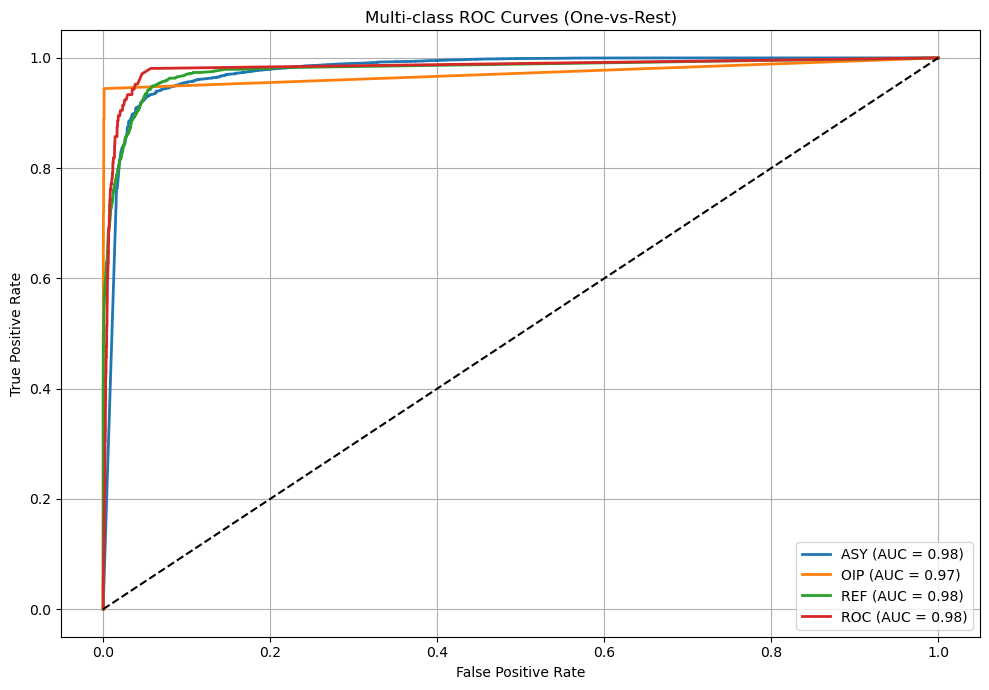

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize labels for ROC curves
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Use One-vs-Rest strategy
ovr_clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
ovr_clf.fit(preprocessor.fit_transform(X_train), y_train)
y_score = ovr_clf.predict_proba(preprocessor.transform(X_test))

# ROC Curves for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multi-class ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


The best performing model is the Random Forest Model.

### Key Takeaways
AsylumRegion, though initially with some missing values, proved to be a critical predictor.

Random Forest delivered the most balanced performance.

Addressing class imbalance (e.g., via resampling, synthetic data) could further improve minority class metrics.